In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import h5py
import scipy.signal as ss
import torch
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
from fnn.distributions import *
from fnn.notebook.utils import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.evaluation import *
import json

In [269]:
f = h5py.File('/home/TRAIN_DATA/15-11-21a/naturalscene.h5', 'r')
repeats_2 = np.array(f['test']['repeats']['binned'])[:,cells,:]

In [14]:
def spike_count(time_bin, each_timing):
    compare = (np.expand_dims(each_timing, -1) > time_bin)
    compare_next = np.zeros(compare.shape)
    compare_next[:, :-1] = compare[:, 1:]
    compare_next[:, -1] = False
    spikes = (compare != compare_next).sum(0)
    return spikes

def time_bin_from_stim(stim_time):
    stim_time = stim_time - stim_time[0]
    stim_time_int = np.append(np.diff(stim_time), 0.03)
    time_bin = np.zeros(stim_time.shape[0]*3)
    time_bin[0::3] = stim_time
    time_bin[1::3] = stim_time + stim_time_int/3
    time_bin[2::3] = stim_time + stim_time_int*2/3
    return time_bin
    
with open('/home/xhding/tem_stim/15-11-21a_expt.json', 'r') as f:
    expt = json.load(f)
g = h5py.File('/home/xhding/tem_stim/15-11-21a/naturalscene.h5', 'r')

h = h5py.File('/home/xhding/tem_stim/photodiode.h5', 'r')
pd = np.array(h['photodiode']['15-11-21-r1'])
peaks = ss.find_peaks(pd, height=1900, distance=90)[0]

test_indices = list(range(3, 24, 4))
cells = [6, 10, 12, 13]

num_trials = len(test_indices)
num_bins = len(expt['stim'][test_indices[0]]['timestamps']) * 3
num_cells = len(cells)
repeats = np.zeros((num_trials, num_cells, num_bins))

for trial, idx in enumerate(test_indices):
    stim_time = np.array(expt['stim'][idx]['timestamps']).squeeze()
    time_bin = time_bin_from_stim(stim_time)
    each_start = peaks[9 + 12*trial] / 10000.
    each_end = each_start + expt['stim'][idx]['timestamps'][-1][0] - expt['stim'][idx]['timestamps'][0][0]
    for cell_idx, cell in enumerate(cells):
        timing = np.array(g['spikes']['cell{:02}'.format(cell+1)])
        each_timing = timing[(timing>each_start) * (timing<each_end)] - each_start
        repeats[trial, cell_idx, :time_bin.shape[0]] = spike_count(time_bin, each_timing)

In [16]:
with h5py.File('/home/xhding/tem_stim/15-11-21a/naturalscene_test.h5', 'w') as f:
    f.create_dataset('test/stimulus', data=g['test/stimulus'])
    f.create_dataset('test/response/binned', data=g['test/response/binned'])
    f.create_dataset('test/response/firing_rate_10ms', data=g['test/response/firing_rate_10ms'])
    f.create_dataset('test/repeats/binned', data=repeats[:,:,:-1])

In [556]:
(repeats != repeats_2).sum()

2

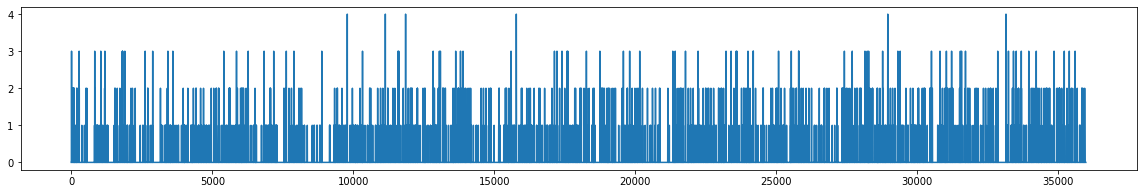

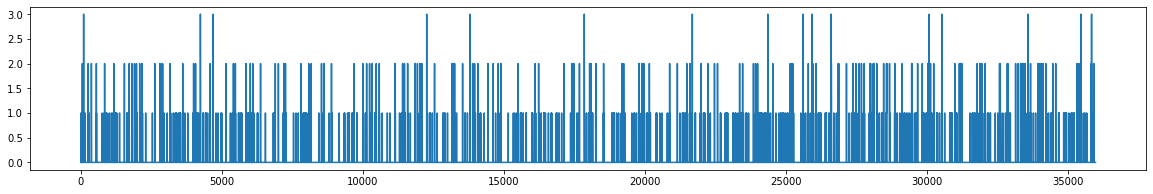

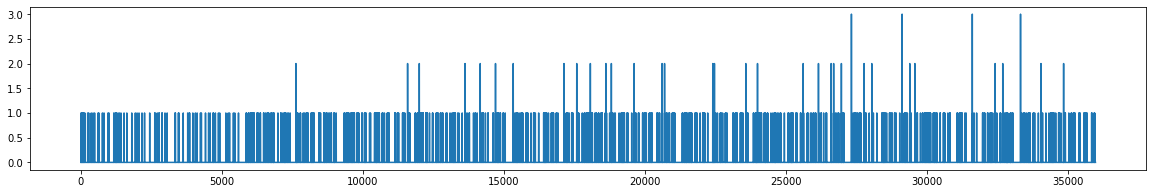

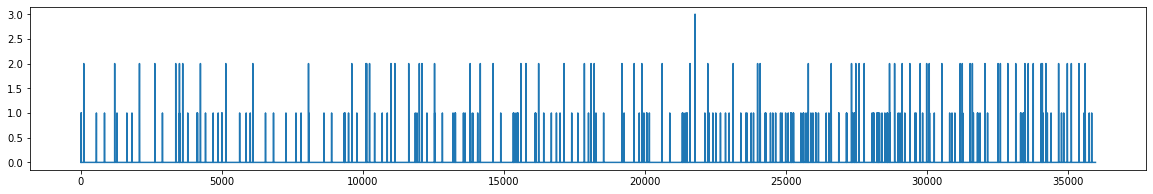

In [566]:
repeats_concat = np.concatenate(repeats, axis=1)
for cell in range(repeats_concat.shape[0]):
    plt.figure(figsize=(20,3))
    plt.plot(repeats_concat[cell])
    plt.show()

In [3]:
file_path = '/home/xhding/tem_stim/15-11-21a/naturalscene_test.h5'
cells = [0, 1, 2, 3]
t_list = [4,4,3,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [586]:
(single_trial_bin[:,:,0] == 4).sum()

6

In [588]:
cell = 0
dist = distribution(t_list[cell])
dist.optimize_k('binomial_scale', single_trial_bin_cut, cell)

1.140625

In [589]:
cell = 1
dist = distribution(t_list[cell])
dist.optimize_k('binomial_scale', single_trial_bin_cut, cell)

1.4482421875

In [590]:
cell = 2
dist = distribution(t_list[cell])
dist.optimize_k('binomial_scale', single_trial_bin_cut, cell)

2.3974609375

In [591]:
cell = 3
dist = distribution(t_list[cell])
dist.optimize_k('binomial_scale', single_trial_bin_cut, cell)

1.0615234375

In [592]:
optimum_para = {}
optimum_para['binomial'] = [1.14, 1.45, 2.40, 1.06]

In [593]:
stats = variance_mean(recording, t_list, optimum_para)

IndexError: list index out of range

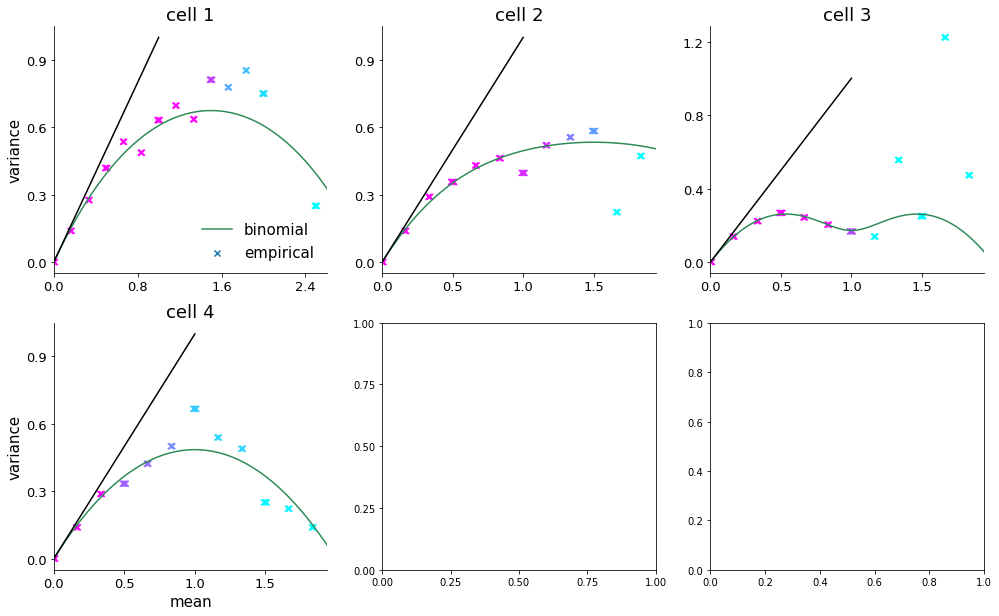

In [594]:
variance_mean_plot(stats, save=None)

In [5]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_15-11-21a')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-11.37_pearson_0.7318.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 4, device)

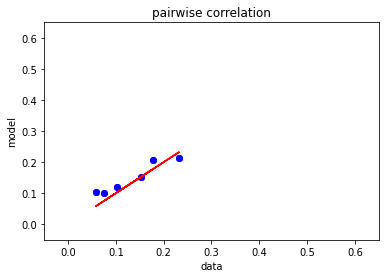

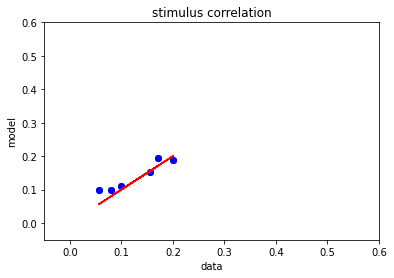

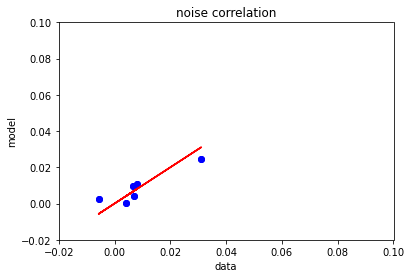

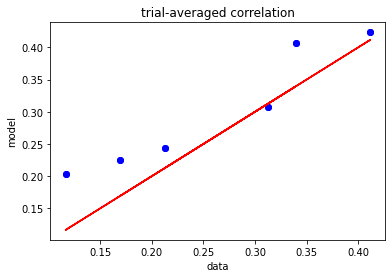

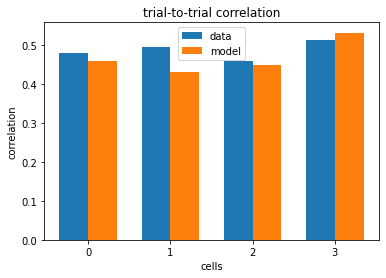

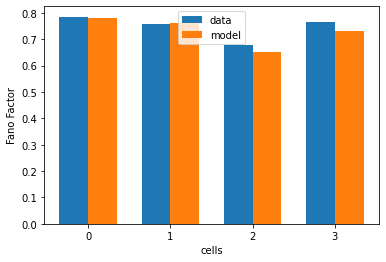

0.010198328147951198


In [31]:
binomial_para = [1.14, 1.45, 2.40, 1.06]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0, 0.15, 0], seed=86)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=13)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr3(single_trial_bin, pred_single_trial, weight=15)[0]
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

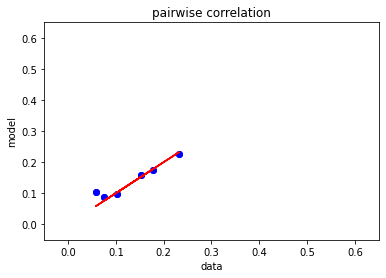

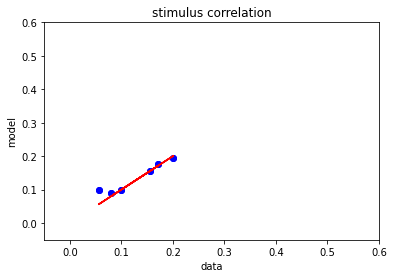

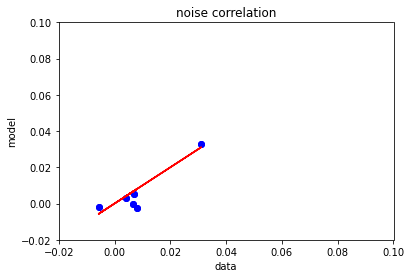

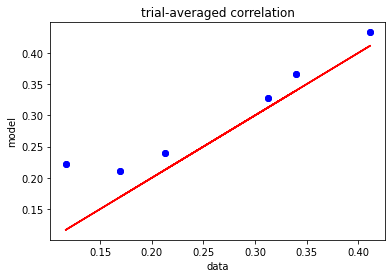

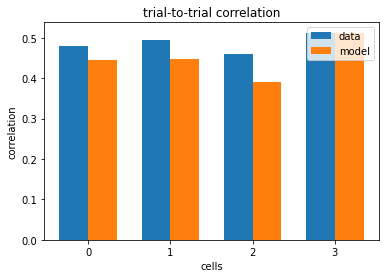

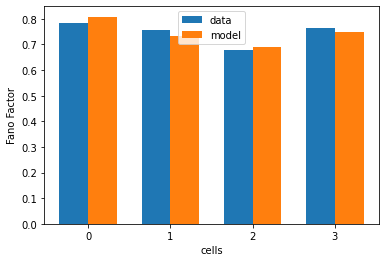

0.009474112618494531


In [33]:
binomial_para = [1.14, 1.45, 2.40, 1.06]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0, 0.15, 0], seed=18)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=18, thre=13)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr3(single_trial_bin, pred_single_trial, weight=15)[0]
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [29]:
for thre in np.arange(1, 15, 0.5):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0, 0.15, 0], 86)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=thre)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr3(single_trial_bin, pred_single_trial, weight=15)[0]
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

1.0 1.1494598470640314
1.5 1.0583258075113893
2.0 0.9807770810681031
2.5 1.0342831433872473
3.0 0.864623026940338
3.5 0.9205696402931156
4.0 0.8573791773601351
4.5 0.8240765469982729
5.0 0.7996752480912942
5.5 0.7629628823516287
6.0 0.6839295437488259
6.5 0.7037408729672296
7.0 0.6699225567137225
7.5 0.5583064152166785
8.0 0.5166258574548015
8.5 0.47862917166774377
9.0 0.4354911893089991
9.5 0.40891271907034865
10.0 0.3630113327332394
10.5 0.35866778740633426
11.0 0.3455660057556738
11.5 0.34272954522453636
12.0 0.3402652041498052
12.5 0.32754205637347444
13.0 0.32990851838328533
13.5 0.3234885850347313
14.0 0.3352941265385512
14.5 0.32325452362462265


In [32]:
for seed in range(100):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0, 0.15, 0], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=13)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr3(single_trial_bin, pred_single_trial, weight=15)[0]
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.016357310912586985
1 0.017072457385212396
2 0.0158952465873498
3 0.013962482514567436
4 0.018346194593920333
5 0.017259890898168217
6 0.01788589877901711
7 0.013241119618944568
8 0.017771733153891453
9 0.01766098420307918
10 0.014116587582239886
11 0.013613762348531198
12 0.016091857432163875
13 0.015446260168800244
14 0.016633789798873998
15 0.020196575944096604
16 0.0125696582410576
17 0.019846300539000196
18 0.009474112618494531
19 0.017844357079826918
20 0.015912454671073113
21 0.015317120802835336
22 0.013297210238785441
23 0.015552335345320694
24 0.011853289098114443
25 0.010216762820930866
26 0.01814457106722849
27 0.020271372311361897
28 0.017604033727725524
29 0.012302295141749596
30 0.0129713749563021
31 0.016138447350463755
32 0.020387342180068622
33 0.013101784857160141
34 0.01128927477885978
35 0.015179853063492704
36 0.01456726655176736
37 0.017302633570418835
38 0.01381283735929217
39 0.014767944735893544
40 0.018617165807806757
41 0.012722196343635174
42 0.021688265

In [35]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [4,4,3,3]

for g2 in np.linspace(0., 0.3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=13)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_noise = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error_noise))

for g1 in np.linspace(0., 0.3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=13)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_noise = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error_noise))

for g0 in np.linspace(0, 3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=13)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_noise = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error_noise))

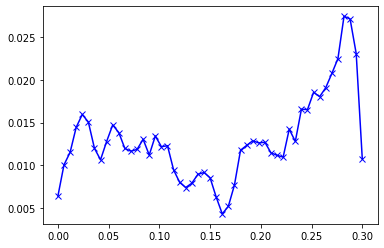

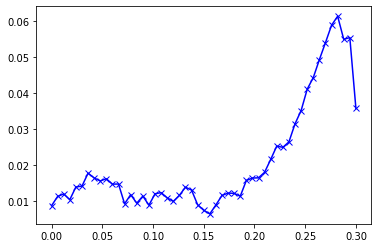

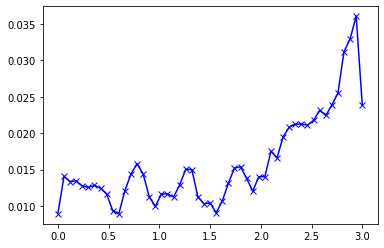

In [36]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

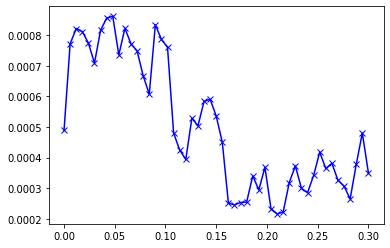

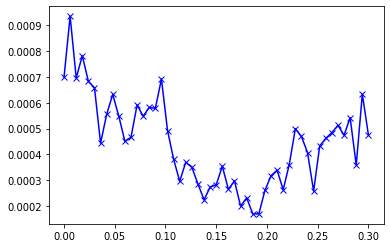

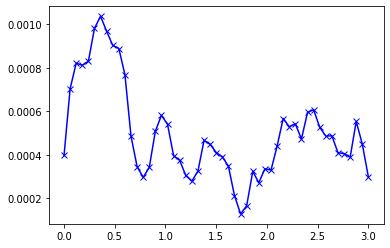

In [37]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

### New Polyfit

In [39]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_15-11-21a')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-11.37_pearson_0.7318.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 4, device, cfg)

0.9150868225097656 91.50868


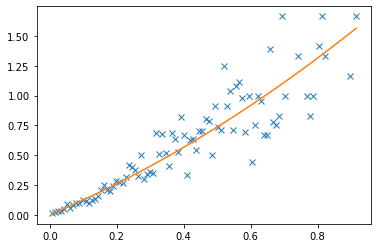

In [51]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 0
means = []
rates = []
sigmas = []
for rate in np.linspace(0.6, pred[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred, cell=cell, rate=rate, intv=0.5)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8 * means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
print(rates.max(), pred[:, cell].max())

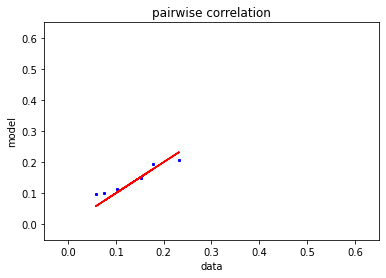

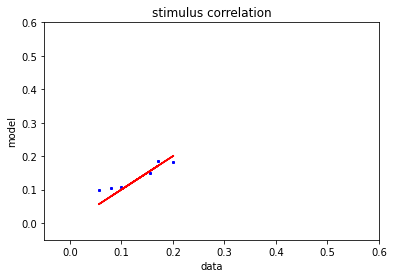

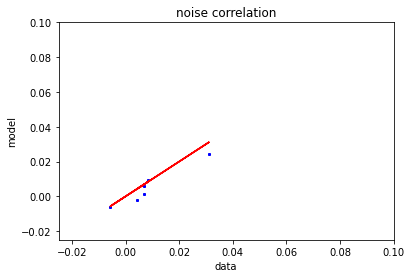

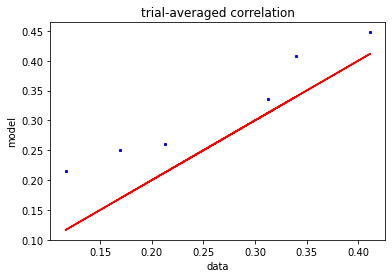

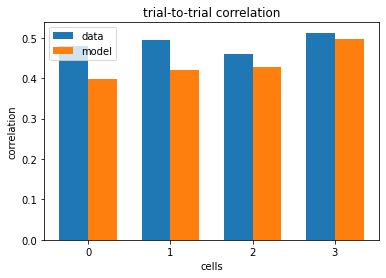

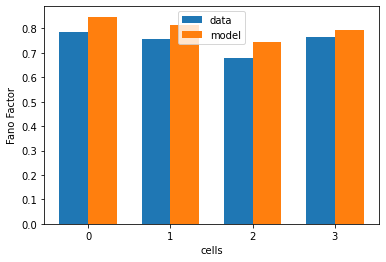

0.00965209398812826


In [91]:
binomial_para = [1.14, 1.45, 2.40, 1.06]
t_list = [4,4,3,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.15, 0.], seed=86)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.3, threshold=0.3, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=1.3)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [99]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(7229.0, 7269)

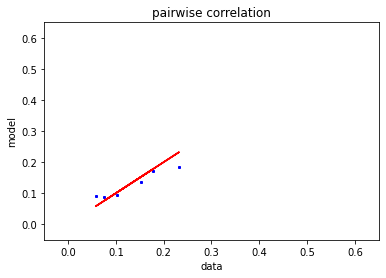

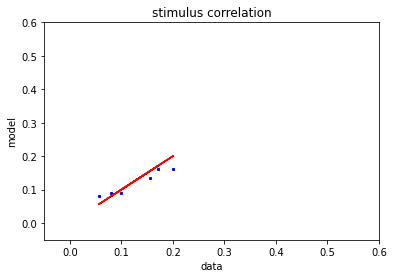

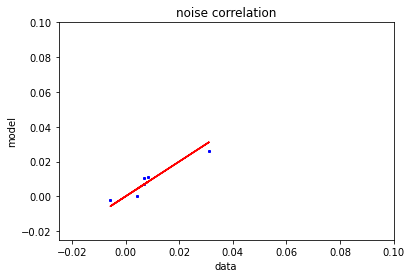

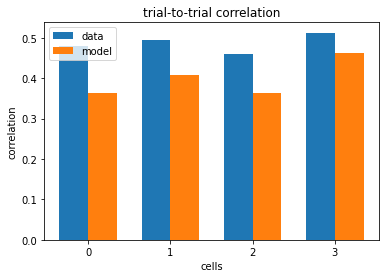

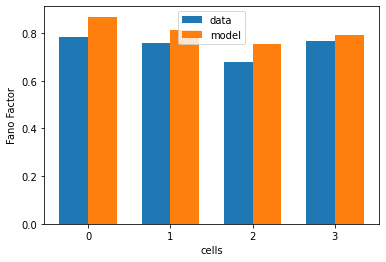

0.008178209338575944
7229.0 7364


In [103]:
binomial_para = [1.14, 1.45, 2.40, 1.06]
t_list = [4,4,3,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.17, 0.], seed=86)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1., threshold=0.3, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=1.)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)
print(single_trial_bin.sum(), pred_single_trial_try.sum())

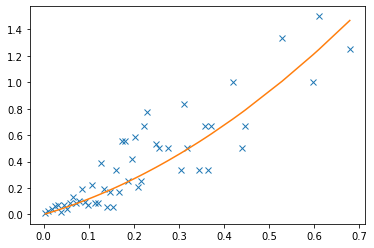

In [111]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 3
means = []
rates = []
sigmas = []
thre = 1
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.4, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.3)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [101]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [4,4,3,3]

for g2 in np.linspace(0., 0.3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, 0, g2, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.2, threshold=0.3, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1.2)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g2_errors.append((g2, min_error_stim, min_error_noise))

for g1 in np.linspace(0., 0.3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, g1, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.2, threshold=0.3, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1.2)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g1_errors.append((g1, min_error_stim, min_error_noise))

for g0 in np.linspace(0, 3, 51):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [g0, 0, 0, 0])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.2, threshold=0.3, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=1.2)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=15)
        if error < min_error:
            min_error = error
            min_error_stim = stim_error
            min_error_noise = noise_error
         
    g0_errors.append((g0, min_error_stim, min_error_noise))

Stimulus correlation


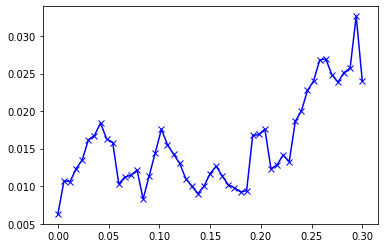

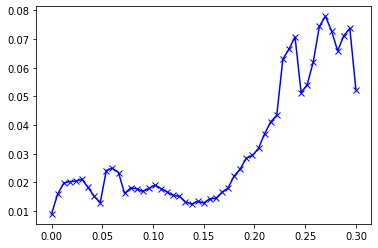

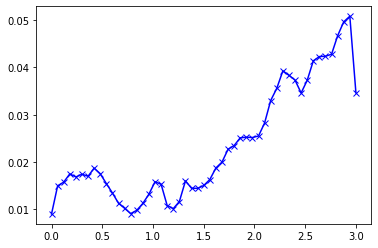

Noise correlation


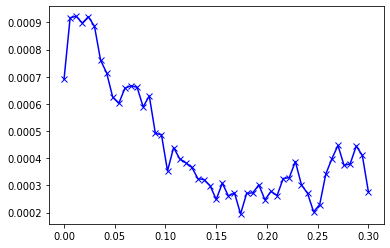

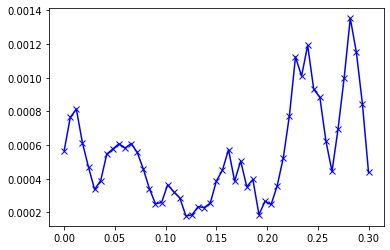

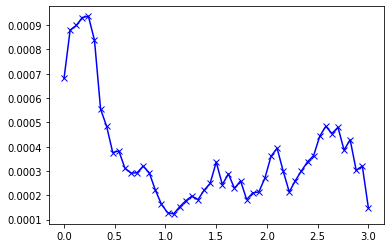

In [102]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

In [7]:
for seed in range(100):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    t_list = [4,4,3,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.17, 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1., threshold=0.3, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=1.2)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=1/15)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.0005893441911304881
1 0.0010233257295997316
2 0.0007149891330495899
3 0.0007936669323548972
4 0.0007527264192992037
5 0.0007578795448457843
6 0.000607826943526976
7 0.0008510826629141465
8 0.0011073991130366716
9 0.0010634127533937193
10 0.0013359917333705784
11 0.0005817174775100873
12 0.0008114184816001959
13 0.0007287156742799773
14 0.0010981439532804604
15 0.001112495393087216
16 0.0007738876416896616
17 0.0009819935647867217
18 0.0006789592118584515
19 0.0012789544811492074
20 0.0005981331560265836
21 0.0005655917200147378
22 0.0006464842255908035
23 0.0008899873941988661
24 0.0009442093302037154
25 0.0007716800597793685
26 0.0007492527692938598
27 0.001128516744156591
28 0.00109941777909121
29 0.000714306274161773
30 0.0006374863590656444
31 0.0011856425169209394
32 0.000540681973401804
33 0.0008517660340829045
34 0.0008314876428033742
35 0.0008607026131630788
36 0.000808980686560403
37 0.0009313428464109142
38 0.0011498246181370555
39 0.000848922981271497
40 0.00077916477692

In [8]:
for seed in range(100):
    binomial_para = [1.14, 1.45, 2.40, 1.06]
    t_list = [4,4,3,3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1., 0., 0., 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1., threshold=0.3, intv=0.3, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=1.2)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=1/15)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.0011335946853112506
1 0.0008100272970201258
2 0.0014888698144329673
3 0.0016220884035270582
4 0.001107098339041697
5 0.0009042601921516755
6 0.001041236105734002
7 0.0007228734474508363
8 0.0009131599760848708
9 0.001528035218570846
10 0.0011389507087993856
11 0.0013288867723827888
12 0.0018471467867410937
13 0.0010720040205133407
14 0.0006695321736709234
15 0.0010891646434826436
16 0.0016653573881388658
17 0.0016742889352385987
18 0.0014975076984399941
19 0.0018721623116086578
20 0.0016798345867991085
21 0.0008116861857643393
22 0.0011978172808066057
23 0.001471038441274342
24 0.001249916909521162
25 0.0011958179068936499
26 0.0012744995545613757
27 0.0023809837008832366
28 0.0014297622049580234
29 0.0013656528884224632
30 0.0011026436423512958
31 0.001525721724570245
32 0.0013617709492549912
33 0.000730971188781291
34 0.0008485968855236846
35 0.0015396490624672195
36 0.0007724558894230591
37 0.0016797330388156095
38 0.0011045899970014584
39 0.0013263850945371347
40 0.000686647314

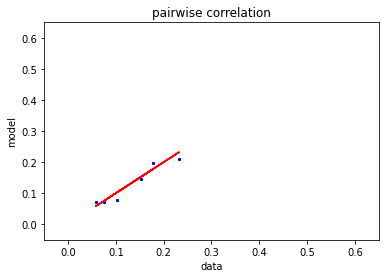

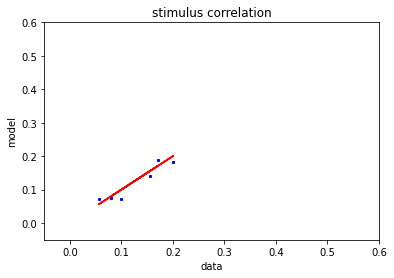

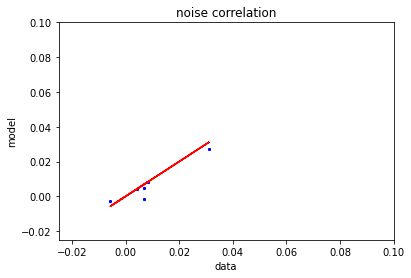

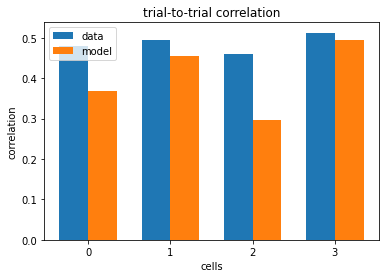

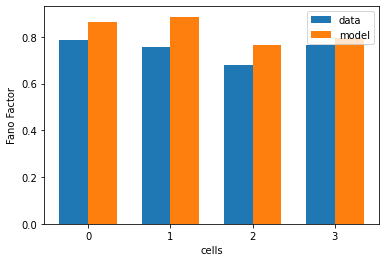

0.0004378855485185353


In [11]:
binomial_para = [1.14, 1.45, 2.40, 1.06]
t_list = [4,4,3,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.17, 0.], seed=51)
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1., threshold=0.3, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=51, thre=1.2)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial, weight=1/15)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)